In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5), (.5))
])

training_data = MNIST(root="D:\\Desktop\\Dev\\AI\\Datasets", train=True, transform=train_transform, target_transform=None)
testing_data = MNIST(root="D:\\Desktop\\Dev\\AI\\Datasets", train=False, transform=transforms.ToTensor(), target_transform=None)
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)


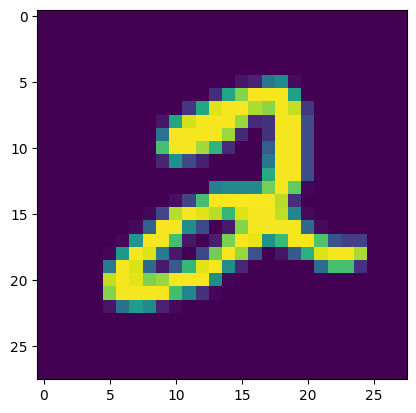

In [3]:
# show an image
X, y = next(iter(train_loader))
plt.imshow(X[5].permute(1,2,0))

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(.4),
            nn.Conv2d(64, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2),
            nn.Dropout(.4),
            nn.Flatten(),
            nn.Linear(64*49, 1),
            nn.Sigmoid()
        )
        
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [21]:
D = Discriminator()

In [6]:
D(X[5].unsqueeze(dim=0))

tensor([[0.7874]], grad_fn=<SigmoidBackward0>)

In [7]:
from torchinfo import summary
print(summary(D))

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       576
│    └─BatchNorm2d: 2-2                  128
│    └─LeakyReLU: 2-3                    --
│    └─Dropout: 2-4                      --
│    └─Conv2d: 2-5                       36,864
│    └─BatchNorm2d: 2-6                  128
│    └─LeakyReLU: 2-7                    --
│    └─Dropout: 2-8                      --
│    └─Flatten: 2-9                      --
│    └─Linear: 2-10                      3,137
│    └─Sigmoid: 2-11                     --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-12                      1,024
│    └─LeakyReLU: 2-13                   --
│    └─Conv2d: 2-14                      131,072
│    └─BatchNorm2d: 2-15                 256
│    └─LeakyReLU: 2-16                   --
│    └─Conv2d: 2-17                      524,288
│    └─BatchNorm2d: 2-18                 512
│ 

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
   

        self.a = nn.Sequential(
            nn.ConvTranspose2d(2, 64 * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
        )
        
        self.b = nn.Sequential(
            nn.ConvTranspose2d(64 * 8, 64 * 4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
        )
        
        self.c = nn.Sequential(
            nn.ConvTranspose2d(64 * 4, 64 * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 1),
            nn.ReLU(True),
        )
        
        self.d = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
        
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.a(x)
        #print(x.shape)
        x = self.b(x)
        #print(x.shape)
        x = self.c(x)
        x = self.d(x)
        
        return x

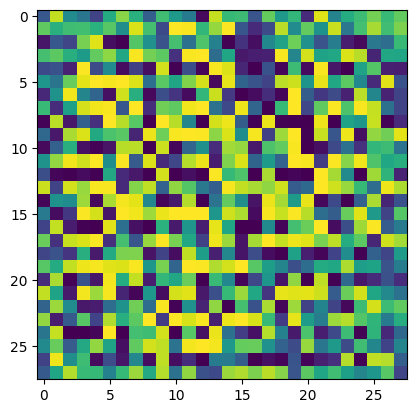

In [23]:
G = Generator()
img = G(torch.randn(1, 2, 1, 1))
img = img.squeeze()
plt.imshow(img.detach().numpy())

In [28]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

device = "cuda"

criterion = nn.BCELoss()

D = Discriminator().to(device)
G = Generator().to(device)

D.apply(weights_init)
G.apply(weights_init)

D_Optimizer = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(.5, .999))
G_Optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(.5, .999))

# D_Optimizer = torch.optim.Adam(D.parameters())
# G_Optimizer = torch.optim.Adam(G.parameters())

In [29]:
epochs = 1000
for epoch in range(epochs):
    for i, (X, y) in enumerate(train_loader):
        X = X.to(device)
        
        D_Optimizer.zero_grad()
        
        b_size = X.size(0)
        
        #update discriminator with real
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = D(X).view(-1)
        dloss_real = criterion(output, label)
        dloss_real.backward()
        D_x = output.mean().item
        
        #update discriminator with fake
        noise = torch.randn(b_size, 2, 1, 1, device=device)
        fake_samples = G(noise)
        label.fill_(0.)
        output = D(fake_samples.detach()).view(-1)
        dloss_fake = criterion(output, label.to(device))
        dloss_fake.backward()
        
        D_Optimizer.step()
        
        #update generator 
        G_Optimizer.zero_grad()
        label.fill_(1.)
        output = D(fake_samples).view(-1)
        gloss = criterion(output, label.to(device))
        gloss.backward()
        G_Optimizer.step()
        
        if i % 50 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, D Loss Real: {dloss_real}, D Loss Fake: {dloss_fake}, G Loss: {gloss}", end="\r")

In [224]:
latent_point = latent_point

In [229]:
latent_point[0][0][0] = 0.841

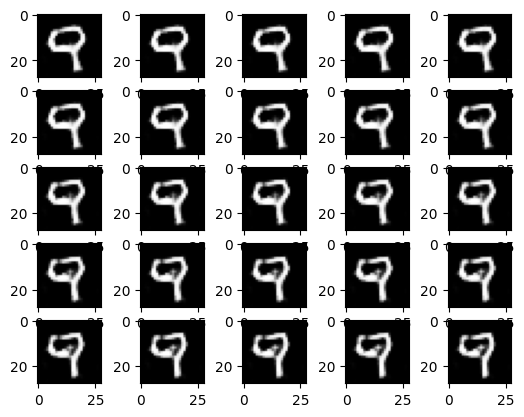

In [241]:
images = 25
f, ax = plt.subplots(5, 5)
latent_point[0][0][0] = 0
for i in range(5):
    for j in range(5): 
        ax[i, j].imshow(G(latent_point.to("cuda")).to("cpu").squeeze().detach().numpy(),cmap="gray")

torch.Size([1, 100, 1, 1])

In [19]:
torch.save(G.state_dict(), "./models/fourth_gan.pth")